# TOP 10% TITANIC - MY APPROACH TO A LEADING SCORE

Hi, thanks for reading. Outlined below I set out the following procedure for predicting the survivability of passengers from the famous Titanic sinking. My approach for building a prediction model is as follows:

1. Load the data
2. Explore the data
3. Modify the data
    3.1 Impute
    3.2 Remove outliers
    3.3 Scale
    3.4 Drop where too many missing values
4. Create new features
5. Build an Sklearn Pipeline
6. Train and Test several models
7. Generate submission file
    

## Import basic packages

In [1]:
import numpy as np
import pandas as pd 
import os
import math
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer

## Load the data

In [2]:
train = pd.read_csv("train (1).csv").set_index('PassengerId')
test = pd.read_csv("test.csv").set_index('PassengerId')

y = train['Survived']
train = train.drop('Survived',axis=1)

display(train.head())
display(test.head())


,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


## View the data

In [3]:
X = pd.concat([train,test])
X.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
X.dtypes

Pclass        int64
Name         object
Sex          object
Age         float64
SibSp         int64
Parch         int64
Ticket       object
Fare        float64
Cabin        object
Embarked     object
dtype: object

In [5]:
X.describe()

,Pclass,Age,SibSp,Parch,Fare
count,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000
mean,2.294882,29.881138,0.498854,0.385027,33.295479
std,0.837836,14.413493,1.041658,0.865560,51.758668
min,1.000000,0.170000,0.000000,0.000000,0.000000
25%,2.000000,21.000000,0.000000,0.000000,7.895800
50%,3.000000,28.000000,0.000000,0.000000,14.454200
75%,3.000000,39.000000,1.000000,0.000000,31.275000
max,3.000000,80.000000,8.000000,9.000000,512.329200


Convert Pclass to categorical, as it is made up of class either 1,2 or 3.

In [6]:
#Pclass is actually categorical
X['Pclass'] = X['Pclass'].astype(object)

num_col = X.select_dtypes(include=['float64','int64']).columns
cat_col = X.select_dtypes(include=['object']).columns

## View the Seaborn Pairplot for Numerical Data

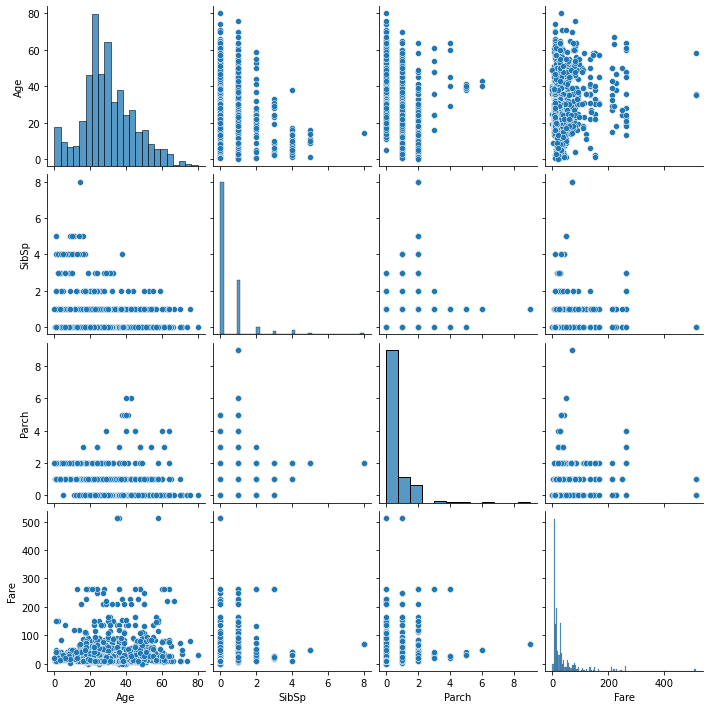

In [7]:
sns.pairplot(X[num_col])

From this, I would make the following points:
* Most of the data is positively skewed
* There are a couple of outliers in Fare
* There are no glaringly obvious strong correlations here

<AxesSubplot:>

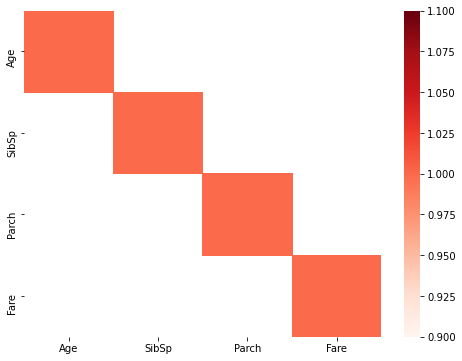

In [8]:
plt.figure(figsize=(8,6))
correlation = X[num_col].corr()
sns.heatmap(correlation, mask = correlation <0.4, cmap='Reds')

As discussed above, there are no correlations between our features here, so there is no **multicolinearity**. What does this mean? In essense a model with features that share some form of relationship won't improve our model. It's probable that it won't negatively effect are model but it's far more likely to result in an overfitted and biased model. Leaving any variables in that have multicolinearity will make your fit appear to be good but when you come to submit the model, you will find poor results. 

## Imputation for Numerical Columns


In [9]:
X[num_col].isnull().sum()

Age      263
SibSp      0
Parch      0
Fare       1
dtype: int64

### Age

In order to deal with the above missing values, we explore a few approaches. The most troublesome at the moment is the missing values in age. Simply imputing the median has a huge effect on the distribution, see charts below:

E:\ANACONDA\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Age Before Imputing')

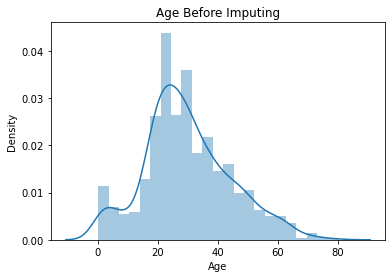

In [10]:
sns.distplot(X.Age).set_title("Age Before Imputing")

Now let's see the median imputed results...

E:\ANACONDA\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Age After Median Imputing')

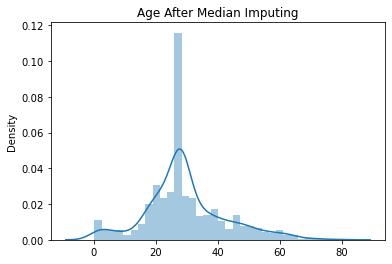

In [11]:
imputer = SimpleImputer(strategy='median')
imputed = imputer.fit_transform(X[['Age']])

sns.distplot(imputed).set_title("Age After Median Imputing")

This isn't great, as our model may end up thinking that being 28 is super important in determining chance of survival, which it probably wasn't. As such, I have created a random imputer in the range 20,55 to retain the distribution. This is a somewhat arbitrary choice and a more scientific method would be preferred but for our purposes here, this should be fine:

In [12]:
def replace_with_random(a):
  
    from random import randint
        
    if pd.isnull(a):
        return randint(20,55)
    else:
        return a

Text(0.5, 1.0, 'Age After Random Imputing')

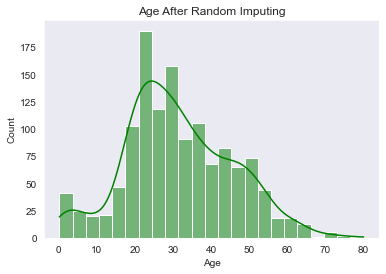

In [13]:
randimpute = X['Age'].apply(lambda a: replace_with_random(a))

sns.set_style('dark')
sns.histplot(randimpute,kde=True,color='green').set_title("Age After Random Imputing")

And this is the direibution of ages we will use.

In [14]:
# For now I will use my random approach for Age
X['Age'] = randimpute

### Fare

There is only one value to impute in Fare, using a median seems sensible

In [15]:
imputer = SimpleImputer(strategy='median')
X['Fare'] = imputer.fit_transform(X[['Fare']])

That should be it for missing data in numerical columns

In [16]:
X[num_col].isnull().sum()

Age      0
SibSp    0
Parch    0
Fare     0
dtype: int64

In [17]:
X.describe()

,Age,SibSp,Parch,Fare
count,1309.000000,1309.000000,1309.000000,1309.000000
mean,31.440542,0.498854,0.385027,33.281086
std,14.099197,1.041658,0.865560,51.741500
min,0.170000,0.000000,0.000000,0.000000
25%,22.000000,0.000000,0.000000,7.895800
50%,30.000000,0.000000,0.000000,14.454200
75%,41.000000,1.000000,0.000000,31.275000
max,80.000000,8.000000,9.000000,512.329200


### ... beautiful!

## Imputation for categorical columns

In [18]:
cat_col = X.select_dtypes(include=['object']).columns
X[cat_col]

,Pclass,Name,Sex,Ticket,Cabin,Embarked
PassengerId,,,,,,
1,3,"Braund, Mr. Owen Harris",male,A/5 21171,NaN,S
2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,PC 17599,C85,C
3,3,"Heikkinen, Miss. Laina",female,STON/O2. 3101282,NaN,S
4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,113803,C123,S
5,3,"Allen, Mr. William Henry",male,373450,NaN,S
...,...,...,...,...,...,...
1305,3,"Spector, Mr. Woolf",male,A.5. 3236,NaN,S
1306,1,"Oliva y Ocana, Dona. Fermina",female,PC 17758,C105,C
1307,3,"Saether, Mr. Simon Sivertsen",male,SOTON/O.Q. 3101262,NaN,S


In [19]:
X[cat_col].isnull().sum()

Pclass         0
Name           0
Sex            0
Ticket         0
Cabin       1014
Embarked       2
dtype: int64

That's a lot of missing data for cabin, lets explore deck from it:

<AxesSubplot:xlabel='Deck', ylabel='count'>

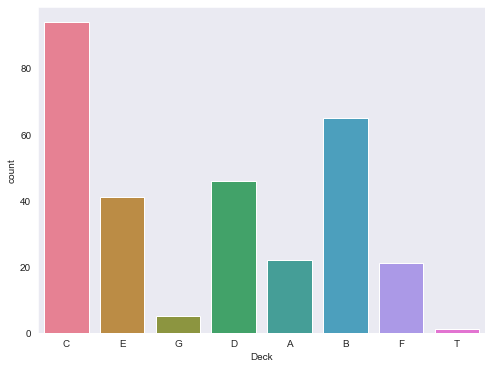

In [20]:
# Do something about cabin feature, at least extract deck where possible
plt.figure(figsize=(8,6))
X['Deck'] = X['Cabin'].str[0]
sns.countplot(x='Deck',data=X,palette="husl")

What does survival look like by Deck?

<AxesSubplot:xlabel='Deck', ylabel='Survived'>

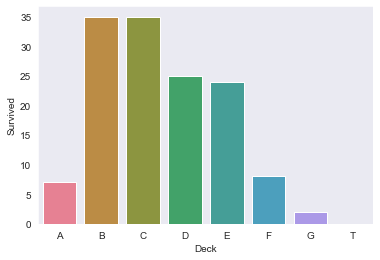

In [21]:
temp_data = pd.merge(X['Deck'],y,on='PassengerId')
temp_data = temp_data.groupby('Deck').sum()
sns.barplot(x=temp_data.index,y=temp_data['Survived'],palette='husl')

So on the limited data we have, clearly being in the upper decks improves survival. It would be nice to include this, but 1,014 values is just too many to impute. For now I will drop Deck/Cabin

An idea would be to try to infer Deck from ticket, as there seems to be some information in there that might help.

In [22]:
X = X.drop(['Cabin','Deck'],axis=1)

In [23]:
cat_col = X.select_dtypes(include=['object']).columns
X[cat_col].isnull().sum()

Pclass      0
Name        0
Sex         0
Ticket      0
Embarked    2
dtype: int64

There are still two missing values for "Embarked", but we will let pipline handle the missing embarked value, see below for embedded iumputation using Sklearn's pipeline functions. There are only 2, so "most common" method should be OK.

## Remove outliers
Back to the numerical data. Let's clean up those outliers from before. Pipline imputation will take care of any missing values

In [24]:
X['Fare'] = X['Fare'][X['Fare']<400]

## Feature Engineering

In order to simplify our features, let's create a family variable that combines Parch and SibSp. It would be preferalble to have 1 dimension with only 60% zeros over 2 dimensions with at least 70% zeros. This is OK to do because, the data Parent/Child and Sibling/Spouse is of the same kind: they are counts of people.

In [25]:
X['FamilySize'] = X['SibSp'] + X['Parch']
X = X.drop(['SibSp','Parch'],axis=1)

num_col = X.select_dtypes(include=['float64','int64']).columns

## Pipline

Here we prepare the pipeline. See sklearn for further imformation

In [26]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='constant')),
    ('scaler',StandardScaler())
    ])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, num_col),
        ('cat', categorical_transformer, cat_col)
    ])

Split the data back into train and test datasets and split for modelling purposes.

In [27]:
# IMPORTANT: Now data is pre-processed, put it back into train and test sets and then split X and y.
test = X.loc[test.index]
X = X.loc[train.index]
y = y.loc[train.index]

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.75,random_state=81)

In [28]:
# Import models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import Perceptron
from sklearn.ensemble import AdaBoostClassifier

In [29]:
"""
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

parameters = {'model__n_estimators':[100,200,500],
              'model__min_samples_split':[2],
              'model__min_samples_leaf':[1]}

scorer = make_scorer(accuracy_score,greater_is_better=True)

grid = GridSearchCV(pipeline,parameters,scoring=scorer)

grid.fit(X_train,y_train)

y_pred = grid.predict(X_test)

accuracy = accuracy_score(y_test,y_pred)

print("Accuracy:",accuracy)

#final_params = grid.best_params_

"""

'\nfrom sklearn.model_selection import GridSearchCV\nfrom sklearn.metrics import make_scorer\n\nparameters = {\'model__n_estimators\':[100,200,500],\n              \'model__min_samples_split\':[2],\n              \'model__min_samples_leaf\':[1]}\n\nscorer = make_scorer(accuracy_score,greater_is_better=True)\n\ngrid = GridSearchCV(pipeline,parameters,scoring=scorer)\n\ngrid.fit(X_train,y_train)\n\ny_pred = grid.predict(X_test)\n\naccuracy = accuracy_score(y_test,y_pred)\n\nprint("Accuracy:",accuracy)\n\n#final_params = grid.best_params_\n\n'

### Random Forest

In [30]:
#Train RF model model, I did a Grid Search CV on this, and it yielded the following setup of parameters:
RandomForest = RandomForestClassifier(n_estimators=500,
                                      min_samples_split=2,
                                      min_samples_leaf=1,
                                      random_state=81)

RF_pipeline = Pipeline(steps=[('preprocessor', preprocessor),('model', RandomForest)])

RF_pipeline.fit(X_train, y_train)

y_pred = RF_pipeline.predict(X_test)

RF_accuracy = accuracy_score(y_test,y_pred)

print("Accuracy:",RF_accuracy)

Accuracy: 0.820627802690583


### Perceptron

In [31]:
Perceptron = Perceptron()

Perc_pipeline = Pipeline(steps=[('preprocessor',preprocessor),('model',Perceptron)])

Perc_pipeline.fit(X_train,y_train)

y_pred = Perc_pipeline.predict(X_test)

Perceptron_accuracy = accuracy_score(y_test,y_pred)

print("Accuracy:",Perceptron_accuracy)

Accuracy: 0.7892376681614349


### Logistic Regression

In [32]:
LogRegCV = LogisticRegressionCV(cv=5)

LR_pipeline = Pipeline(steps=[('preprocessor',preprocessor),('model',LogRegCV)])

LR_pipeline.fit(X_train,y_train)

y_pred = LR_pipeline.predict(X_test)

LogReg_accuracy = accuracy_score(y_test,y_pred)

print("Accuracy:",LogReg_accuracy)

Accuracy: 0.7937219730941704


### Ada Boost

In [33]:
ADA = AdaBoostClassifier()

ADA_pipeline = Pipeline(steps=[('preprocessor',preprocessor),('model',ADA)])

ADA_pipeline.fit(X_train,y_train)

y_pred = ADA_pipeline.predict(X_test)

ADA_accuracy = accuracy_score(y_test,y_pred)

print("Accuracy:",ADA_accuracy)


Accuracy: 0.7443946188340808


## XGBoost

In [34]:
from xgboost import XGBClassifier
classifier = xgb.XGBClassifier(max_depth=12,
                        subsample=0.33,
                        objective='binary:logistic',
                        n_estimators=300,
                        learning_rate = 0.01)
XGB_pipeline = Pipeline(steps=[('preprocessor',preprocessor),('model',classifier)])
XGB_pipeline.fit(X_train,y_train)

y_pred = XGB_pipeline.predict(X_test)

XGB_accuracy = accuracy_score(y_test,y_pred)

print("Accuracy:",XGB_accuracy)


<IPython.core.display.Javascript object>

E:\ANACONDA\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:20:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 0.8116591928251121


### Stacking for all models
This combines all the models, to see if the combined models can predict better. Logistic Regression is used to choose the overall result from amongst the underlying models.

In [35]:
%%time

from sklearn.ensemble import StackingClassifier

estimators = [('RF',RF_pipeline),
              ('Perceptron',Perc_pipeline),
              ('ADA',ADA_pipeline),
              ('classifier',XGB_pipeline),
              ('LogReg',LR_pipeline)]

stack = StackingClassifier(estimators=estimators)
stack.fit(X_train,y_train)
y_pred = stack.predict(X_test)
stack_accuracy = accuracy_score(y_test,y_pred)
print("Accruacy:",stack_accuracy)

E:\ANACONDA\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:20:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


E:\ANACONDA\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:20:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


E:\ANACONDA\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:20:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


E:\ANACONDA\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:20:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


E:\ANACONDA\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:20:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


E:\ANACONDA\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:20:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accruacy: 0.7937219730941704
Wall time: 18.6 s


In [36]:
results = pd.DataFrame({'Model':['Random Forest','Perceptron','Logistic Regression','ADA Boost','XGBoost','Stacked Model'],
                        'Accuracy':[RF_accuracy, Perceptron_accuracy,LogReg_accuracy,ADA_accuracy,XGB_accuracy,stack_accuracy]}).set_index('Model')

In [37]:
results.sort_values('Accuracy',ascending=False)

,Accuracy
Model,
Random Forest,0.820628
XGBoost,0.811659
Logistic Regression,0.793722
Stacked Model,0.793722
Perceptron,0.789238
ADA Boost,0.744395


So the Random Forest model performs best. It is possible that running a GridSearchCV on ADA Boost and Perceptron may lead to better results and ultimately the Stack may improve by extension.

## Generate Submission

When I submitted this, it yielded a score of **0.79186**. Which at time of submission was in the Top 8%.

Thank you for reading. Please upvote if you have enjoyed and leave a comment to indicate any suggestions for improvement, either to my approach or code. 

Thanks again

**Jon**

![UPVOTE](https://i.imgur.com/RVyQY7r.png)

In [38]:
#Choosing RF pipeline, seems best...
test_pred = RF_pipeline.predict(test)

submission = pd.DataFrame(test_pred,index=test.index,columns=['Survived'])

submission.to_csv("rf_submission.csv")